In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch==0.2.1
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model1 = torch.load('/content/drive/MyDrive/Miro_Models/Model/Semantic_SegmentationModel_4.pt',map_location=torch.device('cpu'))
model2 = torch.load('/content/drive/MyDrive/Miro_Models/Model/Semantic_SegmentationModel_5.pt',map_location=torch.device('cpu'))
model3= torch.load('/content/drive/MyDrive/Miro_Models/Model/Semantic_SegmentationModel_6.pt',map_location=torch.device('cpu'))

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
MASK_PATH = '/content/drive/MyDrive/benchmark-complex/'
IMAGE_PATH = '/content/drive/MyDrive/mIOU-complex/'

In [ ]:
class MiroTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            mask = mask/255
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


X_test = ['image1','image2','image3','image4']

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = MiroTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

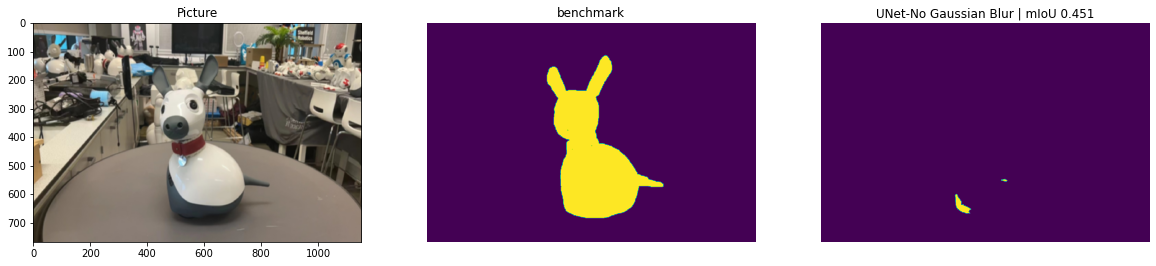

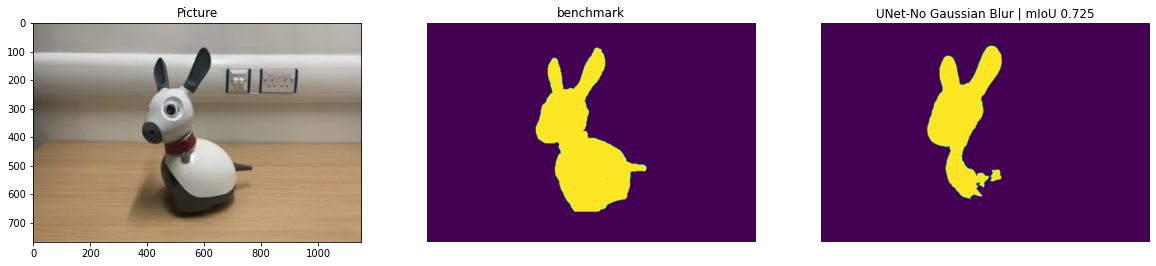

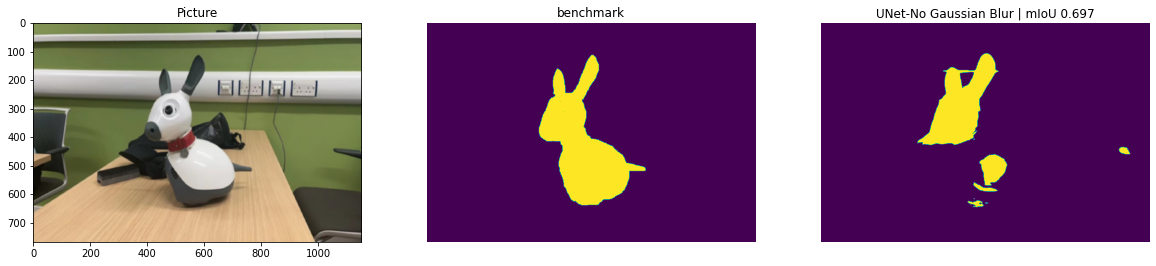

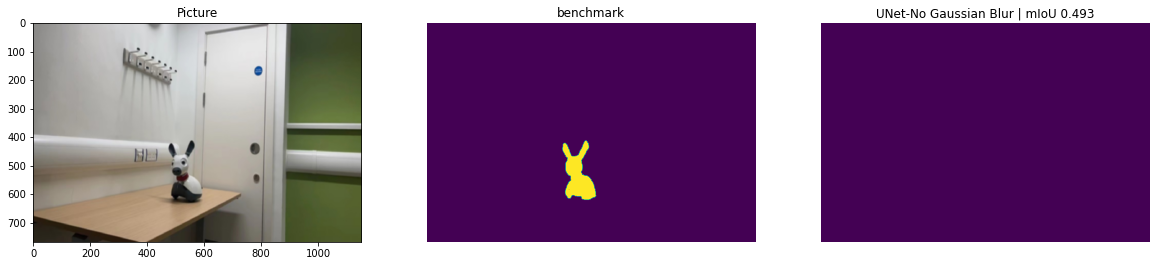

In [ ]:
for i in range(0,4):
  image, mask = test_set[i]
  pred_mask,score = predict_image_mask_miou(model1, image, mask)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('benchmark')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-No Gaussian Blur | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

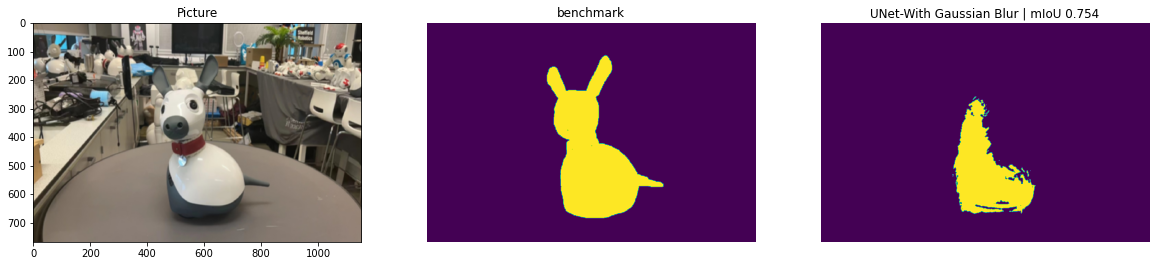

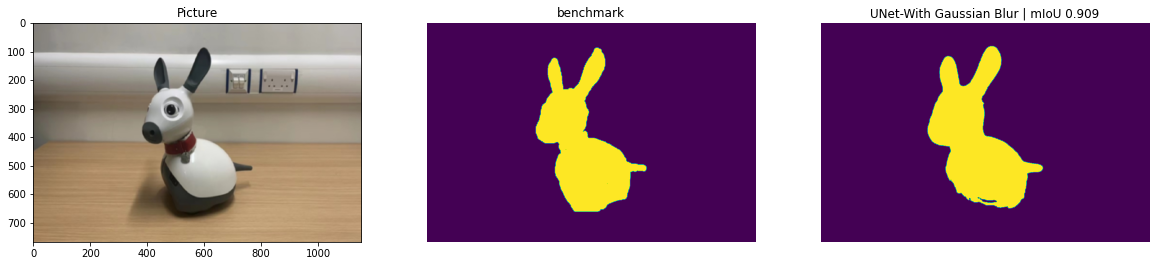

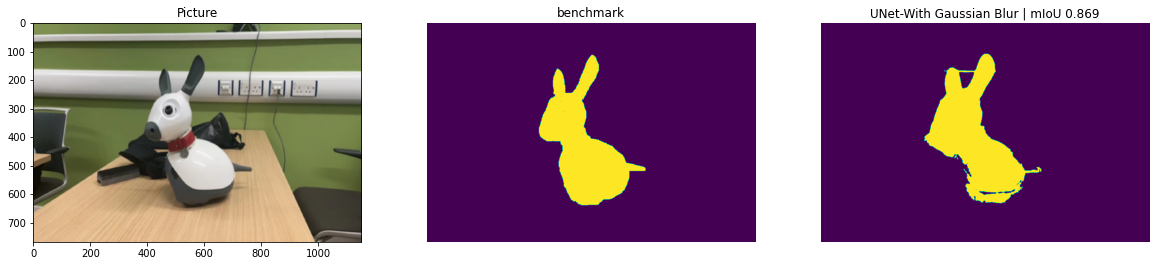

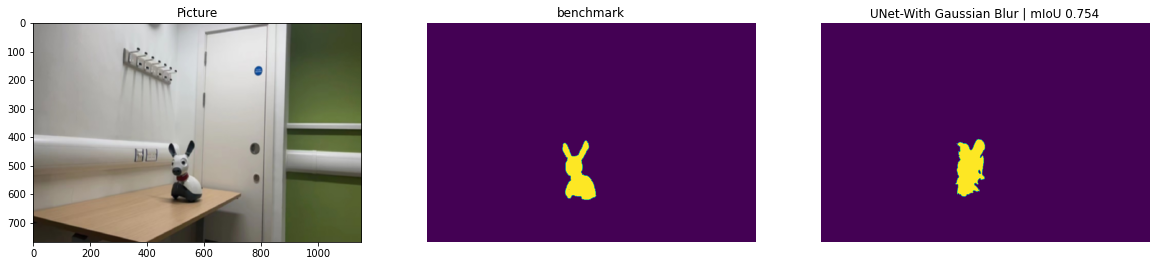

In [ ]:
for i in range(0,4):
  image, mask = test_set[i]
  pred_mask,score = predict_image_mask_miou(model2, image, mask)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('benchmark')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-With Gaussian Blur | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

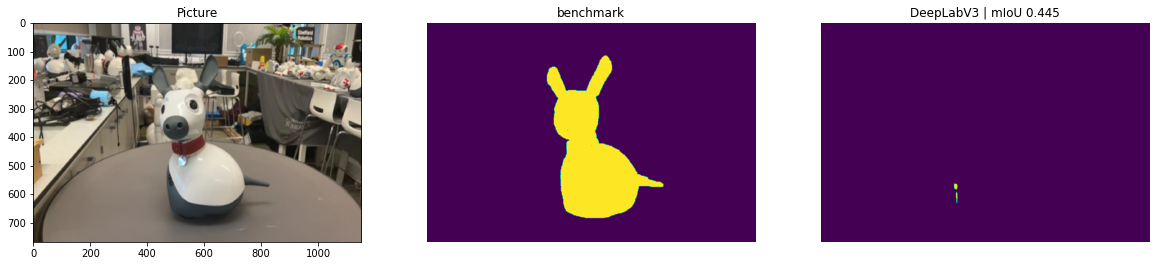

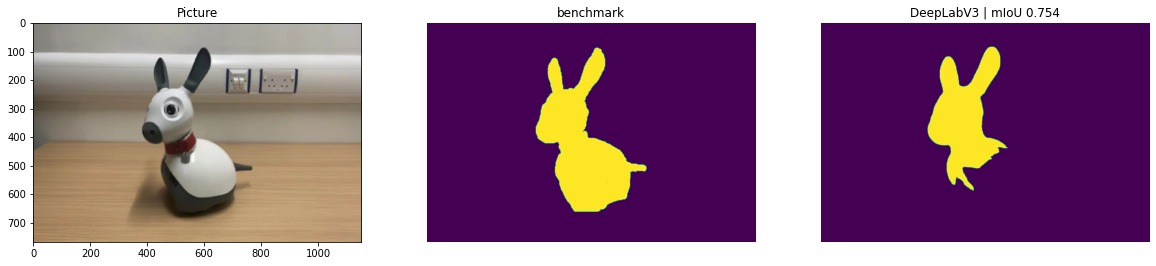

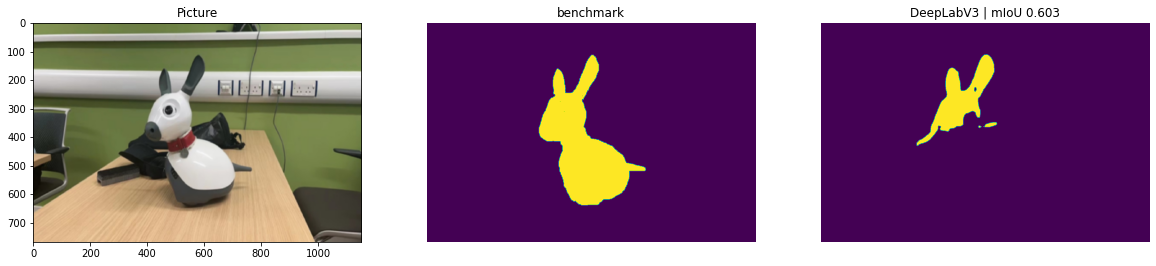

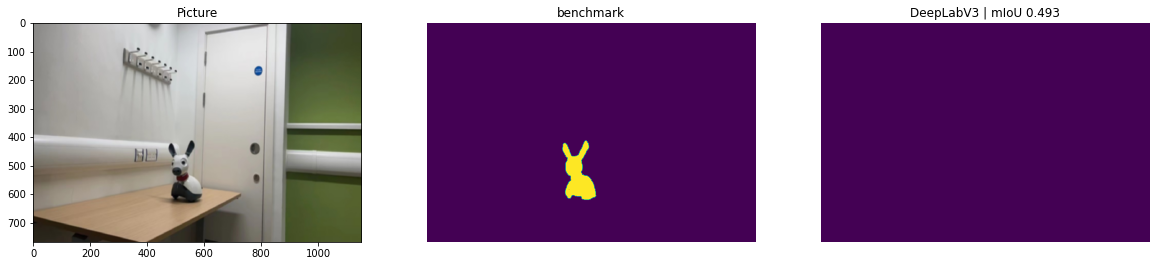

In [ ]:
for i in range(0,4):
  image, mask = test_set[i]
  pred_mask,score = predict_image_mask_miou(model3, image, mask)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('benchmark')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('DeepLabV3 | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

In [ ]:
mob_miou1 = miou_score(model1, test_set)
mob_miou2 = miou_score(model2, test_set)
mob_miou3 = miou_score(model3, test_set)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(mob_miou1)
print(sum(mob_miou1)/len(mob_miou1))

[0.4514373951733137, 0.7245813866690893, 0.6965573963037602, 0.49268030237268906]
0.5913141201297131


In [ ]:
print(mob_miou2)
print(sum(mob_miou2)/len(mob_miou2))

[0.7543856800166077, 0.9086147660261026, 0.8686764005997796, 0.7535465877752456]
0.8213058586044337


In [ ]:
print(mob_miou3)
print(sum(mob_miou3)/len(mob_miou3))

[0.44521869226856126, 0.7538977131489905, 0.602683563708879, 0.49268030237268906]
0.5736200678747799
